<a href="https://colab.research.google.com/github/Saifullah785/deep-learning-projects/blob/main/Project_14_flickr8k_Image_Caption_Generator/Project_14_flickr8k_Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling1D, GlobalMaxPooling2D, Activation, Dropout, Flatten, Dense, Input,Layer
from tensorflow.keras.layers import Embedding, LSTM, Add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style('dark')
warnings.filterwarnings('ignore')

**Image** **Captioning**

In [16]:
import os

# Set Kaggle configuration directory to find kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

# Download the dataset
!kaggle datasets download -d adityajn105/flickr8k

# Unzip the dataset
!unzip -q flickr8k.zip -d flickr8k

# Verify the contents (optional, but good for debugging)
!ls flickr8k

In [7]:
# Update the image_path and load the captions.txt file
image_path = './flickr8k/Images'
data = pd.read_csv("./flickr8k/captions.txt")
display(data.head())

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


**visualization**

In [8]:
def readImage(path, img_size=224):
  img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img/255
  return img

def display_images(temp_df):
  temp_df = temp_df.reset_index(drop=True)
  plt.figure(figsize= (20, 20))
  n = 0
  for i in range(15):
    n+=1
    plt.subplot(5, 5, n)
    plt.subplots_adjust(hspace=0.7, wspace=0.3)
    image = readImage(f"{image_path}/{temp_df.image[i]}")
    plt.imshow(image)
    plt.title("\n".join(wrap(temp_df.caption[i], 20)))
    plt.axis('off')

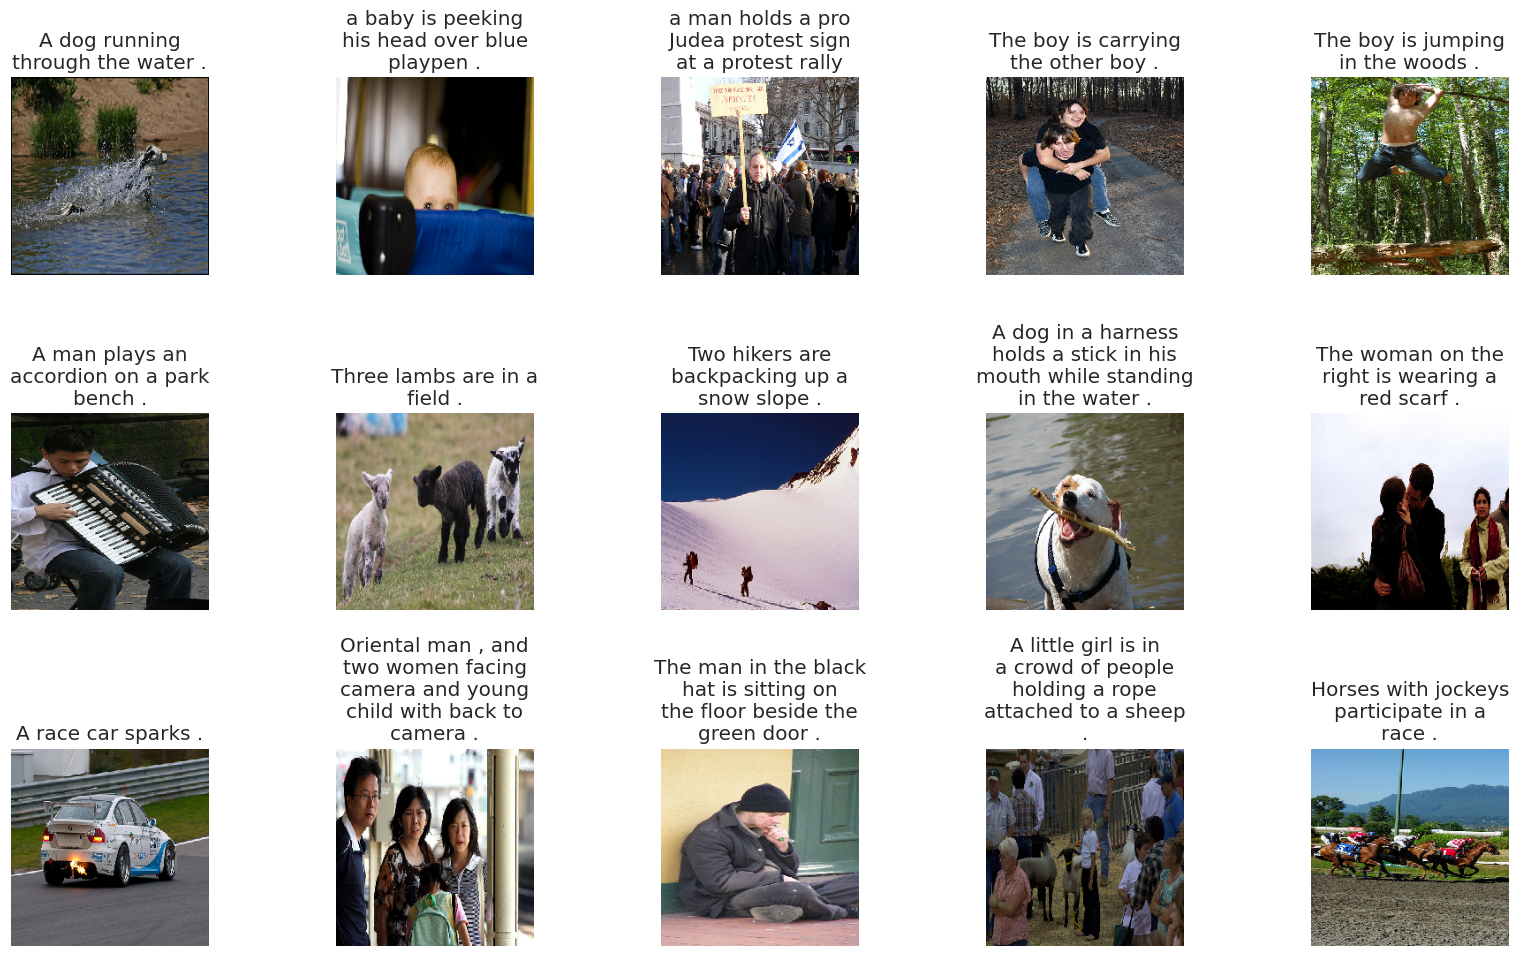

In [9]:
display_images(data.sample(15))

# **Caption Text Preprocesssing Steps**

In [10]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data

data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenization and Encoded Representation

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Images Feature Extraction**

In [15]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature